In [1]:
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import uniform
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# make toy dataset
X, y = make_moons(n_samples= 400, noise=.1, random_state= 42)

# convert raw data to pandas dataframe
df = pd.DataFrame(X, columns= ["feature_1", "feature_2"])

# get data dimensions
n, m = df.shape

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


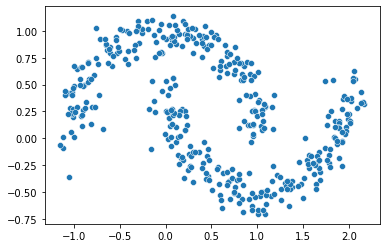

In [3]:
# ploting data
sns.scatterplot(X[:, 0], X[:, 1])

In [4]:
df.head()

,feature_1,feature_2
0,-0.044052,0.436078
1,0.692230,-0.401119
2,0.828198,0.541522
3,0.178812,0.268862
4,0.091715,0.946118


In [5]:
def mark_border(x, df, tree, esp):
    # get the index of neighbors
    neighbor_index_list = tree.query_radius(np.array(x.values).reshape(-1, 2), esp)
    
    neighbor_df = df.iloc[neighbor_index_list[0]]
    
    #check if core point exist in nearest neighbors
    contains_core_point = neighbor_df.is_core.str.contains('Y').any()
    if contains_core_point:
        return "Y"
    return "N"

def DBSCAN(df, eps, min_point):
    
    # kd tree for fast neighbor search
    points = df.values
    feature_columns = df.columns
    tree = KDTree(points)
    
    # create visited coulmn
    df["visited"] = -1
    
    # add cluster column
    df["cluster"] = -1
    
    # add border column
    df["is_border"] = "N"
    
    # mark core point
    df["is_core"] = tree.query_radius(df[feature_columns], eps, count_only=True)
    df["is_core"] = df["is_core"].apply(lambda x: "Y" if x >= min_point else "N")
    
    # mark border point
    df["is_border"] = df[df.is_core == "N"][["feature_1",\
                                             "feature_2"]].apply(mark_border, df= df, tree= tree, esp= eps, axis= 1)
    
    # fill nan values
    df.is_border.fillna("N", inplace= True)
    
    
    sample_core_point_list = []
    c = 0
    while 1:
        
        # get the list of unvisited core points
        core_df = df[(df.is_core == "Y") & (df.visited == -1)][feature_columns]
        
        # base case (return once all the core points are visited)
        if core_df.shape[0] == 0:
            break
        
        # select a single core point at random fron unvisited list
        sample_core_point = core_df.sample(random_state= None)
        
        # get the index of sampled core point
        core_idx = sample_core_point.index.values[0]
        
        # append the selected core point to the core point list
        sample_core_point_list.append(sample_core_point)
        
        # visit every density connected point and assign it to a cluster
        q = [core_idx]

        # do until we visit every density connected point
        while q:
            # get the current core point index
            core_p_idx = q.pop(0)
            
            # get the vector of current core point
            core_p = df[feature_columns].iloc[core_p_idx].values.reshape(-1, 2)
            
            # check if core point is unvisited
            if df.iloc[core_p_idx].visited == -1:
                
                # get the indicies of points close to current core point within given eps
                neighbor_idx = tree.query_radius(core_p, eps)
                
                '''
                'query_radius' returns list with numpy array as element [array([138, 187], dtype=int64)]
                '''
                
                # get the neighboring point as a dataframe
                core_neighbor_points = df.iloc[neighbor_idx[0]]

                # select only core point neighbor
                core_neighbor_points = core_neighbor_points[core_neighbor_points.is_core == "Y"]

                # select only feature columns (igore columns [cluster, visited])
                core_neighbor_points = core_neighbor_points[feature_columns]

                # add it to the queue, to visit it later
                q.extend(core_neighbor_points.index)
                
                # add current core point to the cluster
                df.loc[core_p_idx, "cluster"] = c
                # mark current core point to the cluster
                df.loc[core_p_idx, "visited"] = 1
        c += 1
    return df, sample_core_point_list, tree

In [6]:
df_tmp, core_point, tree  = DBSCAN(df.copy(deep= True), 0.15, 6)

In [7]:
df_tmp.cluster.value_counts()

 1    181
 0    178
-1     41
Name: cluster, dtype: int64

In [8]:
df_tmp.head()

,feature_1,feature_2,visited,cluster,is_border,is_core
0,-0.044052,0.436078,1,0,N,Y
1,0.692230,-0.401119,1,0,N,Y
2,0.828198,0.541522,1,1,N,Y
3,0.178812,0.268862,1,0,N,Y
4,0.091715,0.946118,1,1,N,Y


In [9]:
df_tmp.is_core.value_counts()

Y    359
N     41
Name: is_core, dtype: int64

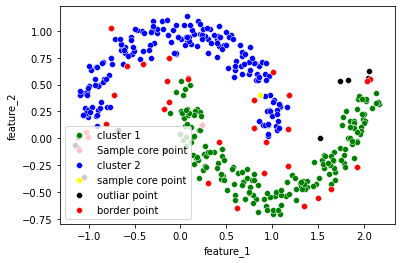

In [10]:
sns.scatterplot(x= "feature_1", y= "feature_2", data= df_tmp[df_tmp.cluster == 0], color= "green", label= "cluster 1")
sns.scatterplot(x= "feature_1", y= "feature_2", data= core_point[0], color= "pink", label= "Sample core point")

sns.scatterplot(x= "feature_1", y= "feature_2", data= df_tmp[df_tmp.cluster == 1], color= "blue", label= "cluster 2")
sns.scatterplot(x= "feature_1", y= "feature_2", data= core_point[1], color= "yellow", label= "sample core point")

sns.scatterplot(x= "feature_1", y= "feature_2", data= df_tmp[df_tmp.is_core == "N"], color= "black", label= "outliar point")

sns.scatterplot(x= "feature_1", y= "feature_2", data= df_tmp[df_tmp.is_border == "Y"], color= "red", label= "border point")